# Extraction du texte 

Maintenant que l'on a repéré les décisions qui nous intéressent, on peut isoler certaines données dans ces décisions pour pouvoir faire des statistiques dessus.

L'objectif de ce notebook est d'en extraitre le plus possible, notamment :

- décision finale (oui/non)
- lieu où la décision a été prise
- quel type d'acteur (particulier / entreprise)
- pour chaque type d'acteur : M. ou Mme / quelle forme juridique
- quel avocat fait la défense (cabinet / M. ou Mme)
- quel est le montant en jeux 
- qui compose le tribunal 
- quelles sont les lois citées

Un notebook suivant fera une analyse plus fine de la défense en analysant le texte.

In [3]:
! pip install -q numpy pandas

You should consider upgrading via the '/Users/basiledesjuzeur/Documents/legal_analysis/venv_legal/bin/python3 -m pip install --upgrade pip' command.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml
import os


On ne prend que les décisions qui nous intéressent

In [4]:
df = pd.read_csv('../data/intermediate_data.csv')

# décisions sur les majorations
df = df[(df.ordonnance_de_renvoi == False) & (df.majoration != 'other')]

# sauvegarde des données
df.to_csv('../data/final_data.csv', index=False)


/var/folders/lt/7s5dvrb13ll759vbj0xtstr40000gp/T/ipykernel_1798/732327320.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/intermediate_data.csv')


On inspecte des décisions aléatoires pour se donner une idée de la structure

In [9]:
random = df.sample(1)

random_path = random['path'].values[0]

print("Majoration : ", random['majoration'].values[0])

# open file in vscode
os.system(f'code {random_path}')

Majoration :  40%


0


### 1. Décision finale

Est ce que la demande a été acceptée ?

Il y a environ 600 décisions qui n'ont pas donné lieu à un rejet, cela confirme que l'étude est intéressante !



In [20]:
# function to read and parse xml file
def read_xml(file_path):
    with open(file_path, 'r') as file:
        xml_data = file.read()
    return xml.dom.minidom.parseString(xml_data)

# function to get the result of the recours with result of previous function
def get_result(xml_data):
    result = xml_data.getElementsByTagName('Solution')[0].firstChild.data
    return result


# read random file
random = df.sample(1)

print("Majoration : ", random['majoration'].values[0])

# get result
print("Décision : ",get_result(read_xml(random['path'].values[0])))

# open file in vscode to check
os.system(f'code {random["path"].values[0]}')



Majoration :  40%
Décision :  Rejet


0

Après quelques tests ça fonctionne bien.

In [24]:
df["décision"] = df["path"].apply(lambda x: get_result(read_xml(x)))

df["décision"].value_counts()

décision
Rejet                            1697
Satisfaction partielle            408
Satisfaction totale               132
Non-lieu                           64
Désistement                        12
ADD - Expertise / Médiation         4
Rejet défaut de doute sérieux       2
Renvoi                              1
Avis article L.113-1                1
Radiation des registres             1
Name: count, dtype: int64

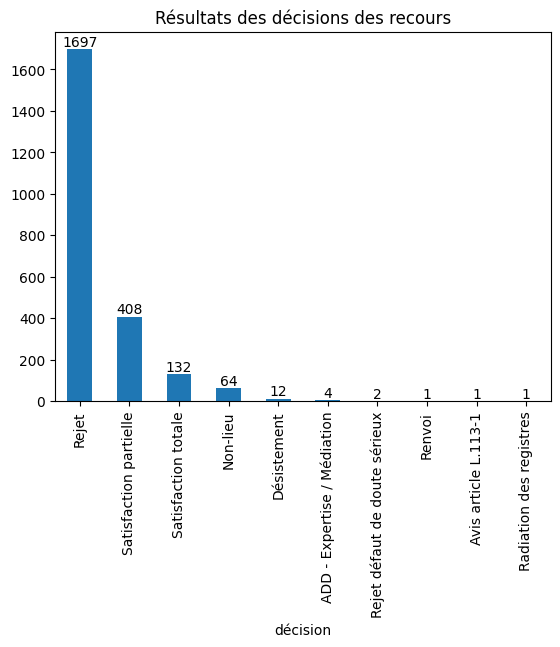

In [48]:
plot , ax = plt.subplots()

ax = df["décision"].value_counts().plot(kind='bar', title='Résultats des décisions des recours')

# display number of each bar
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height(), i.get_height(), ha='center', va='bottom')

plt.show()

# save plot 
plot.savefig('../data/resultats_des_decisions.png')


### 2. Lieu où la décision a été prise

Pour pouvoir faire des analyses géographiques

In [40]:
def get_location(xml_data):
    
    code_juridiction = xml_data.getElementsByTagName('Code_Juridiction')[0].firstChild.data #TA69

    # keep only numbers
    code = ''.join(filter(str.isdigit, code_juridiction)) #69
    
    # nom juridiction
    try :
        nom_juridiction = xml_data.getElementsByTagName('Nom_Juridiction')[0].firstChild.data
    except:
        nom_juridiction = None

    return code, nom_juridiction


# read random file
random = df.sample(1)

# get result
code, nom = get_location(read_xml(random['path'].values[0]))
print("Code juridiction : ", code)
print("Nom juridiction : ", nom)


# open file in vscode to check
os.system(f'code {random["path"].values[0]}')



Code juridiction :  77
Nom juridiction :  Tribunal Administratif de MELUN


0

Après quelques tests ça fonctionne bien.

In [41]:
df["code_juridiction"], df["nom_juridiction"] = zip(*df["path"].apply(lambda x: get_location(read_xml(x))))

Pour pouvoir faire une carte, on a besoin de pouvoir situer chaque tribunal administratif

In [45]:
path = df[df.code_juridiction =='108'].path.values[0]
os.system(f'code {path}')

0

df.code_juridiction